**5_Partial_Denpendency_Plot**

A Partial Dependence Plot (PDP) shows the relationship between a feature (or features) and the predicted outcome of a model, averaging out the effects of all other features. It is a graphical depiction of the marginal effect of a variable on the response. The term "partial" refers to the fact that the dependence is calculated while **keeping all other features constant**.

 For instance, if you have a model that predicts housing prices, a PDP could show how prices typically increase with the size of the house, irrespective of the location or the number of rooms.

Here's how a PDP is typically generated:

    
   
    

1.   Select a feature for which you want to understand its partial dependence on the predicted outcome.
2.    For each unique value of the selected feature, fix that value and average over the possible values of all other features.
3.   Plot the averaged predictions against the unique values of the selected feature.



Partial dependence plots are particularly useful for interpreting the behavior of complex models like ensemble trees or gradient boosting machines, as they can give you insights into the effect of a single feature after the model has accounted for interactions between features. However, PDPs can be misleading if there is a strong correlation between features since changing one feature while holding others constant may result in unlikely or impossible combinations of features.

**Objective:** Generate the partial dependency plots for the top 5 features in your best Random Forest model from the previous assignment. Use the population distribution (%) as the primary y-axis and the response rate (%) as the secondary y-axis. To identify the best bin edges you can use a single tree model with the feature of interest or you can pick values that you feel are relevant. Make sure that appropriate scaling of the axis is used for the best visualization and interpretation. +3 Bonus points if you identify and plot any interesting 2D plot (i.e. two variables at a time).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Data Import

mth_features = pd.read_csv('Monthly_Features.csv')
# Drop rows with any missing values
mth_features.dropna(inplace=True)
mth_features = mth_features.drop(columns='Unnamed: 0')
mth_features.head()

,CLNT_NO,ME_DT,mth_txn_amt_sum,mth_txn_cnt,amt_sum_3M,amt_mean_3M,amt_max_3M,txn_cnt_sum_3M,txn_cnt_mean_3M,txn_cnt_max_3M,...,txn_cnt_max_12M,cnt_Friday,cnt_Monday,cnt_Saturday,cnt_Sunday,cnt_Thursday,cnt_Tuesday,cnt_Wednesday,days_since_last_txn,response
1,CS1112,2011-06-30,56.0,1.0,56.0,28.000000,56.0,1.0,0.500000,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15.0,0.0
3,CS1112,2011-08-31,96.0,1.0,152.0,50.666667,96.0,2.0,0.666667,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0
5,CS1112,2011-10-31,60.0,1.0,156.0,52.000000,96.0,2.0,0.666667,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,29.0,0.0
11,CS1112,2012-04-30,56.0,1.0,56.0,18.666667,56.0,1.0,0.333333,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,22.0,0.0
13,CS1112,2012-06-30,52.0,1.0,108.0,36.000000,56.0,2.0,0.666667,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0


In [3]:
# Prepare the data
X = mth_features.drop(columns=['CLNT_NO', 'ME_DT', 'response'])
y = mth_features['response']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


**Random Forest Model**

Best parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}

In [14]:
# Train the Random Forest model
rf = RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=200, random_state=0)
rf.fit(X, y)

RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=200,
                       random_state=0)

In [15]:
# Get feature importances and find the top 5 features
importances = rf.feature_importances_
indices = np.argsort(importances)[-5:]
top_5_features = X.columns[indices]
top_5_features

Index(['amt_max_6M', 'amt_mean_6M', 'amt_max_12M', 'amt_mean_12M',
       'amt_sum_12M'],
      dtype='object')

In [8]:
top_5_features = ['amt_max_6M', 'amt_mean_6M', 'amt_max_12M', 'amt_mean_12M',
       'amt_sum_12M']

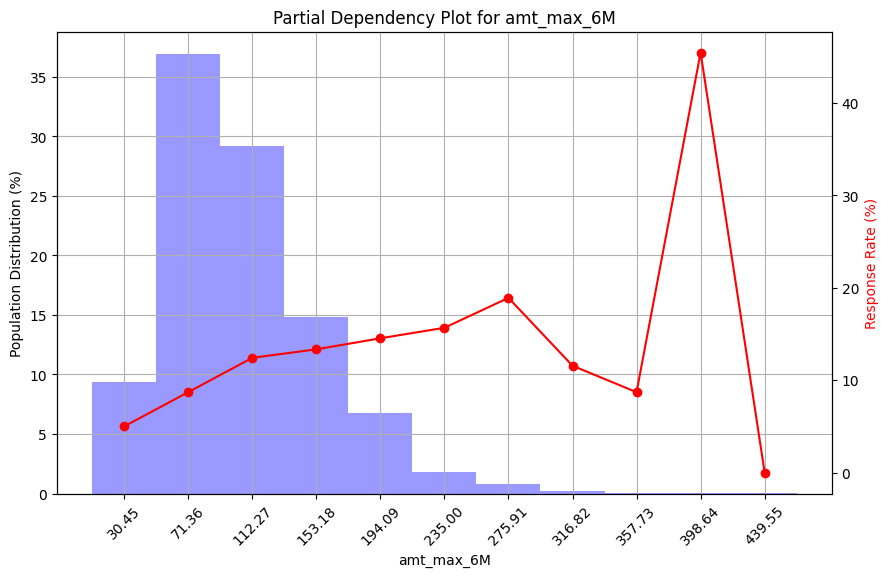

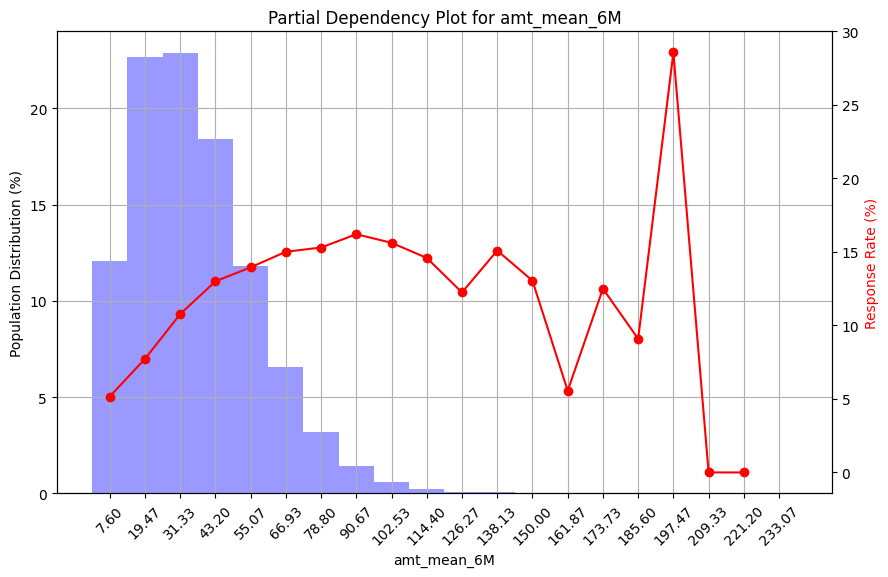

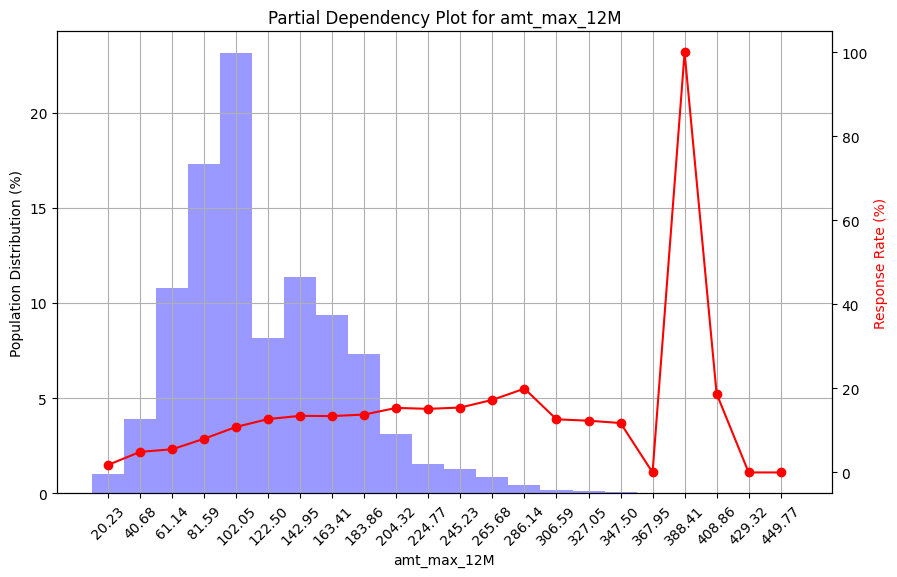

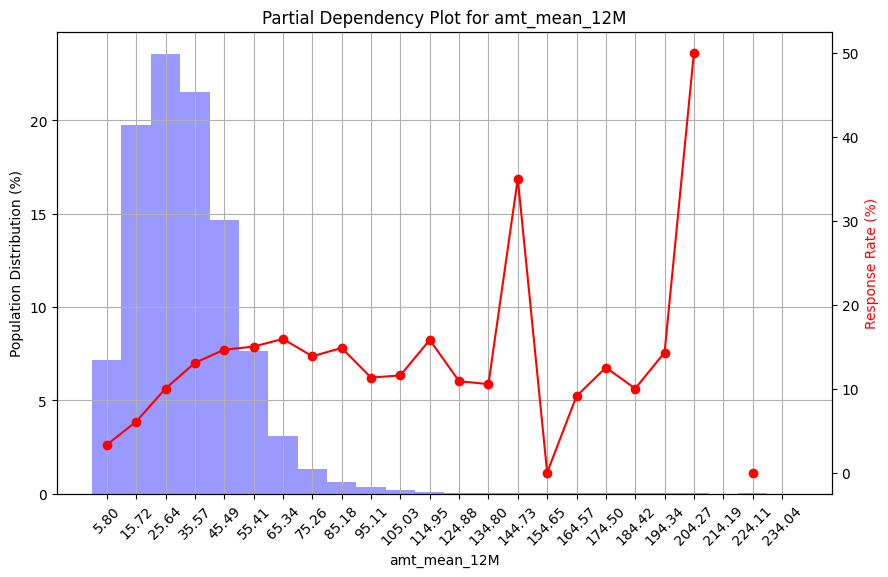

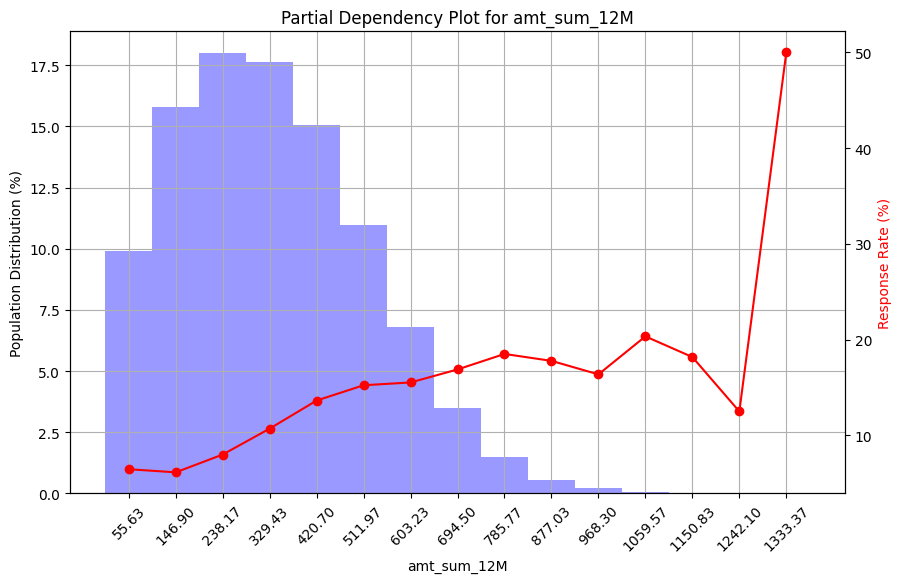

In [11]:
import matplotlib.pyplot as plt
import numpy as np

dt = DecisionTreeClassifier(max_depth=2)

for feature in top_5_features:

    X_feature = mth_features[[feature]]
    y = mth_features['response']

    # Fit the single decision tree
    dt.fit(X_feature, y)
    # Determine bin edges from the decision tree splits and calculate the average bin size
    bin_edges = dt.tree_.threshold[dt.tree_.feature >= 0]
    # bin_edges = np.sort(bin_edges)[1:-1]  # Sort and remove extremes
    fixed_bin_size = round(np.mean(np.diff(sorted(bin_edges))))  # Calculate the fixed bin size as the rounded mean of bin differences

    # Calculate bins based on the fixed bin size and the range of the feature
    feature_range = mth_features[feature].max() - mth_features[feature].min()
    num_bins = int(np.ceil(feature_range / fixed_bin_size))
    bins = np.linspace(mth_features[feature].min(), mth_features[feature].max(), num_bins + 1)

    # Calculate the population distribution and express it as a percentage
    population_distribution, _ = np.histogram(mth_features[feature], bins=bins)
    population_distribution_pct = (population_distribution / population_distribution.sum()) * 100

    # Calculate the response rate for each bin
    response_rate = []
    for i in range(len(bins) - 1):
        mask = (mth_features[feature] >= bins[i]) & (mth_features[feature] < bins[i+1])
        response_rate.append(mth_features.loc[mask, 'response'].mean() * 100)

    # Plot population distribution as a histogram
    plt.figure(figsize=(10, 6))
    response_value = (bins[:-1] + bins[1:]) / 2

    plt.xticks(response_value, labels=[f"{val:.2f}" for val in response_value], rotation=45)

    ax1 = plt.gca()  # Get current axis
    # Calculate weights for each entry so that the histogram represents percentages
    weights = np.ones_like(mth_features[feature]) / len(mth_features[feature]) * 100

    # Plot population distribution as a histogram
    ax1.hist(mth_features[feature], bins=bins, weights=weights, color='blue', alpha=0.4, label='Population Distribution (%)')
    ax1.set_xlabel(feature)
    ax1.set_ylabel('Population Distribution (%)')

    # response_value = (bins[:-1] + bins[1:]) / 2
    # Create secondary y-axis for response rate
    ax2 = ax1.twinx()
    ax2.plot(response_value, response_rate, marker='o', linestyle='-', color='red', label='Response Rate (%)')
    ax2.set_ylabel('Response Rate (%)', color='red')


    # Final plot adjustments
    ax1.set_title(f'Partial Dependency Plot for {feature}')
    ax1.grid(True)
    plt.show()


**Result Interpretation**

The series of Partial Dependency Plots indicate the relationship between various 6-month and 12-month financial metrics (maximum, mean, and sum) and a certain response rate in a dataset.

Starting with the first plot for `amt_max_6M`, we see a relatively stable population distribution across most of the value range, with a significant population concentration in the lower bins. The response rate appears to have a general increasing trend as the `amt_max_6M` increases, but with a significant spike in the highest bin. This suggests that higher maximum amounts over a 6-month period are associated with a greater likelihood of a response, but particularly so at the very top range.

The second plot, `amt_mean_6M`, shows a similar population distribution, with most of the population having lower mean amounts over 6 months. The response rate fluctuates and then spikes at higher values, indicating a possible threshold effect where the response rate dramatically increases past a certain average amount.

Moving to the `amt_max_12M` metric, the population distribution is more evenly spread out across the range, but there's a dramatic spike in the response rate at the upper end. This could suggest that there is a strong correlation between higher maximum amounts over a 12-month period and the response rate, with the highest amounts showing the most significant effect.

The fourth plot for `amt_mean_12M` reveals a generally decreasing population distribution as the mean amount increases, with sporadic response rate spikes. The most substantial spike at the end of the scale again suggests a potential threshold where higher mean amounts lead to substantially higher response rates.

Lastly, the `amt_sum_12M` plot has a distribution skewed towards lower sum amounts over 12 months, with a sharp increase in response rate at higher values. It appears that total sums over a year do not significantly affect response rates until they reach the higher end of the spectrum.

Across all five plots, we see a common theme where the response rate is relatively low for smaller financial metrics but increases — sometimes dramatically — at higher values. This could inform financial or risk management strategies, where particular attention might be given to these higher financial figures, as they indicate a higher probability of the response event occurring.


**Bonus 3 points-2D Plots**



In [20]:
top_5_features

Index(['amt_max_6M', 'amt_mean_6M', 'amt_max_12M', 'amt_mean_12M',
       'amt_sum_12M'],
      dtype='object')

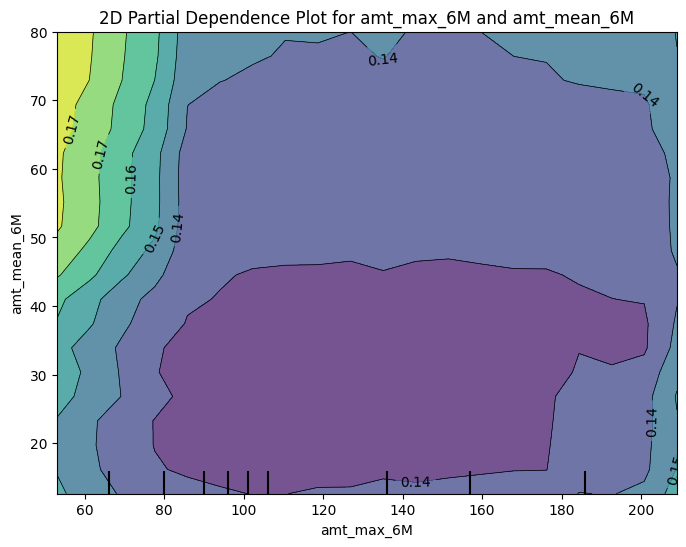

In [18]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(8, 6))

# Plot the 2D partial dependence
PartialDependenceDisplay.from_estimator(
    rf,
    X[:5000],
    features=[(top_5_features[0], top_5_features[1])],
    kind="average",
    ax=ax,
    grid_resolution = 20
)

ax.set_title(f'2D Partial Dependence Plot for {top_5_features[0]} and {top_5_features[1]}')
ax.set_xlabel(top_5_features[0])
ax.set_ylabel(top_5_features[1])

# Show plot
plt.show()

The image illustrates the relationship between two numerical features—`amt_max_6M` and `amt_mean_6M`—and their impact on a model's predictions.

From what we can observe, `amt_max_6M`, represented on the x-axis, spans a range of approximately 60 to 200 units, while `amt_mean_6M` on the y-axis varies from around 20 to 80 units. The contours in the plot, differentiated by shades of blue to yellow, denote levels of prediction by the model. The darker shades of blue, particularly the large region in the plot, suggest a lower impact on the model's predictions. Conversely, the lighter shades, transitioning to yellow, indicate a higher impact or a stronger association with the predicted outcome.

The plot does not exhibit a strong gradient or distinct pattern, implying that the interaction between `amt_max_6M` and `amt_mean_6M` may not have a pronounced or simple linear influence on the model's predictions. The stable values of prediction across a wide range of `amt_max_6M` values, especially when `amt_mean_6M` lies between 30 to 60, suggest that other features not displayed here might have a more significant role in influencing the model's output.

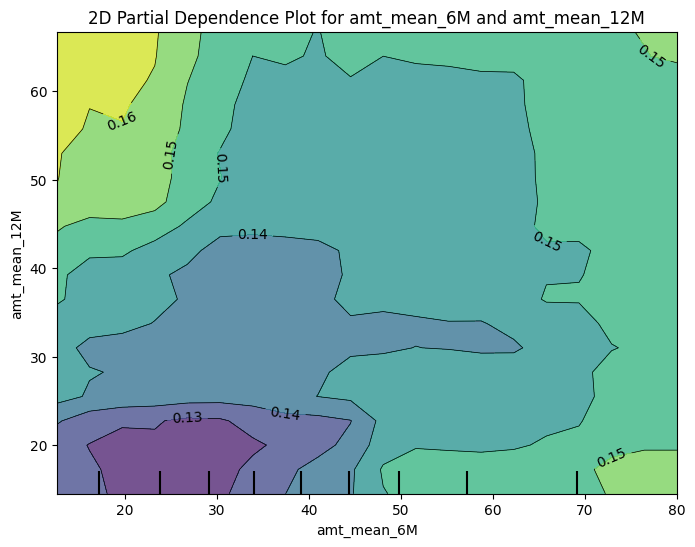

In [21]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(8, 6))

# Plot the 2D partial dependence
PartialDependenceDisplay.from_estimator(
    rf,
    X[:5000],
    features=[(top_5_features[1], top_5_features[3])],
    kind="average",
    ax=ax,
    grid_resolution = 20
)

ax.set_title(f'2D Partial Dependence Plot for {top_5_features[1]} and {top_5_features[3]}')
ax.set_xlabel(top_5_features[1])
ax.set_ylabel(top_5_features[3])

# Show plot
plt.show()

One observation from the plot is the gradation of color from yellow to dark blue, representing an increase to a decrease in the model's predicted value. The yellow area at the top left suggests that lower values of amt_mean_6M combined with higher values of amt_mean_12M are associated with higher predictions from the model. The largest dark blue area, at the bottom, indicates that higher amt_mean_6M and lower amt_mean_12M values lead to the lowest predictions.

Interestingly, the plot suggests a nonlinear relationship between the two features and the prediction. This is especially evident by the fact that the regions of equal prediction are not evenly spaced and show some curvature, indicating a more complex interaction between these features as they relate to the model's outcome.




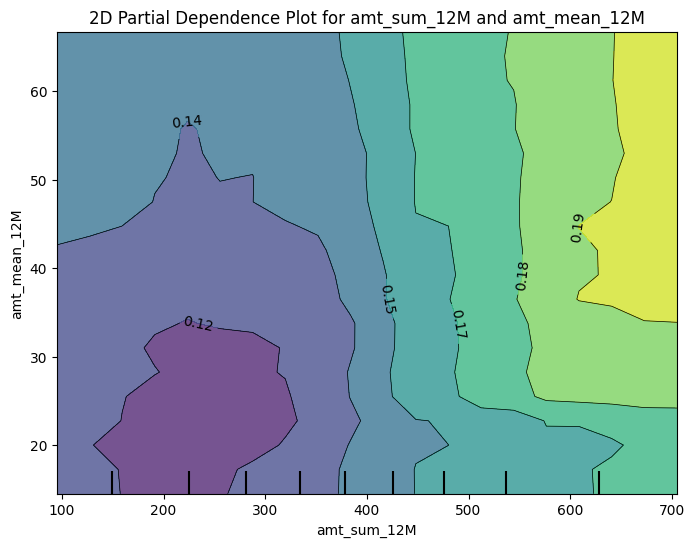

In [22]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(8, 6))

# Plot the 2D partial dependence
PartialDependenceDisplay.from_estimator(
    rf,
    X[:5000],
    features=[(top_5_features[4], top_5_features[3])],
    kind="average",
    ax=ax,
    grid_resolution = 20
)

ax.set_title(f'2D Partial Dependence Plot for {top_5_features[4]} and {top_5_features[3]}')
ax.set_xlabel(top_5_features[4])
ax.set_ylabel(top_5_features[3])

# Show plot
plt.show()

We can discern that there's a distinct pattern: the prediction increases as both the sum and the mean amounts over the past 12 months increase. This is especially noticeable with the yellow region indicating the highest prediction values, which occurs at the highest amt_sum_12M and amt_mean_12M values shown on the plot.